# Machine learning for anomaly detection and condition monitoring

In this second part of anomaly detection on credit card data, we apply downsampling methods.


One popular way to deal with imbalanced data is by undersampling.
Undersampling works by sampling the dominant class to reduce the number of samples. One simple way of undersampling is randomly selecting a handful of samples from the class that is overrepresented.  There are dedicated libraries like the  RandomUnderSampler class from the imblearn library.
The following are some techniques to deal implemented in the library.
  - over sammpling SMOTE
  - Undersampling - Random UnderSampler
  - Combined class methods  SMOTE + ENN

At the moment, we use the naive implementation to simply sample the majority class at random until reaching a similar number of observations as the minority classes. Subsequently the **imbalance** library will be used.

The down sampled data will be visualized using [t-Distributed Stochastic Neighbor Embedding (t-SNE)](http://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf), a technique well suited for the visualization of high-dimensional datasets by projections to 2D.


Various models including RandomForestsClassifier are trained to predict fraudulent transactions. Without doing anything to tackle the issue of imbalanced data, our model was able to achieve 100% precision for the negative class label. 

### 1. Importing the useful packages

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns
import numpy as np
import pandas as pd


from time import time

from numpy.random import seed
seed(20)

#Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn import manifold
from sklearn import preprocessing

# Model selection
from sklearn.model_selection import train_test_split
# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Pickle
import joblib
import os

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, balanced_accuracy_score
from sklearn.metrics import precision_recall_curve #for different thresholds
from sklearn.model_selection import cross_validate, KFold, cross_val_score

#Algorithms that will be trained
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier

Changing the size of the default parameter sizes

In [2]:
%matplotlib inline
#sns.set()
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          #'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
#plt.style.use('fivethirtyeight')

### 2. Load the data explore it

A continuation of with the credit card dataset. The date contains transactions made by credit cards in September 2013 by Europesn card holders. The transaction occured in two days, within which 492 fraudulent purchases were made in over 284, 807 transaction. As explored earlier, it is an example of an imbalanced dataset with the positive class __(identifying fraud)__ contributing only 0.17% of all transaction. Note that the data is already anonymized with the columns representing the PCAs.

In [3]:
df = pd.read_csv('data/creditcard.csv')

In [4]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

The class 1 is Fraud and 0 is normal

In [5]:
df["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [6]:
(df.Class.value_counts()/df.shape[0])*100

0    99.827251
1     0.172749
Name: Class, dtype: float64

It is clear that the data is highly unbalanced. Let's expand on this by making a bar plot

## Correlations between attributes

A look at the plots above indicates some distinctive features in the legimate and fraudulent transactions as a function of time. Could there be a significant difference in the days?

Create columns of scaled time and amount in the data frame

In [7]:
scaled_time = StandardScaler().fit_transform(df[['Time']])
scaled_amount= StandardScaler().fit_transform(df[['Amount']])

In [8]:
df['s_time'] = scaled_time
df['s_amount'] = scaled_amount

In [9]:
df.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,s_time,s_amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,-1.996583,0.244964
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,-1.996583,-0.342475


Drop the Time and Amount columns

In [10]:
data = df.drop(['Time', 'Amount'], axis=1)

In [11]:
data.head(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,s_time,s_amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,-1.996583,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-1.996583,-0.342475


At this point, it is a good idea to split the data into two parts from which we will subsequenty get the test and train data

In [12]:
# Stratify sampling of 80% trainig set and  20% test set
data_train, data_test  = train_test_split(data, test_size= 0.2, 
                                                    random_state = 42, stratify = data.Class)

In [13]:
print("The shape of train is {0} and the test is {1}".format(data_train.shape, data_test.shape))

The shape of train is (227845, 31) and the test is (56962, 31)


In [14]:
sum(data_test.Class==1)

98

Datatest will be kept for testing. It contains 98 fraudulent transactions out of the 56962 transactions. On the other hand, data_train has 394 fraudulent  transaction out of the 227, 845. 

In [15]:
data_train.head(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,s_time,s_amount
265518,1.946747,-0.752526,-1.355130,-0.661630,1.502822,4.024933,-1.479661,1.139880,1.406819,-0.157403,...,0.297537,0.307915,0.69098,-0.350316,-0.388907,0.077641,-0.032248,0,1.413095,-0.323963
180305,2.035149,-0.048880,-3.058693,0.247945,2.943487,3.298697,-0.002192,0.674782,0.045826,0.284864,...,0.228197,0.035542,0.70709,0.512885,-0.471198,0.002520,-0.069002,0,0.624644,-0.341275


In [16]:
sum(data_train.Class == 1)

394

For example, with the majority class of 284315 observations and a minority class of 492 observations, we collect training data for the majority class by randomly sampling 492 observations from the original 284315. This method could potentially result in removing key characteristics of the majority class.

We will apply the idea of undersampling. What we do is randomly sample an equal number of legimated data and then combine it with the fraudulent data. Perform a sub sampling of the fraudulent data with the same number of sample as the fraudulent data

In [17]:
def gen_balanced_data(data):
    '''
    Fucntion to generate a balanced data from an imbalanced data. 
    The return data will be a balanced set that will be used for ML
    '''
    non_fraud = data[data.Class == 0] #non fraudulent data identified with class 0
    fraud = data_train[data_train.Class == 1] #fraudulent data identified with class 1
    
    #sample an amount equal to len of fraude
    selected = non_fraud.sample(len(fraud))
    #concatenating both into a subsample data set with equal class distribution
    selected.reset_index(drop=True, inplace=True)
    fraud.reset_index(drop=True, inplace=True)    
    
    #concate into a subsample dataset with equal class distribution
    sub_sampled_data = pd.concat([selected, fraud])
    
    return sub_sampled_data    

In [18]:
sub_sampled_data = gen_balanced_data(data)

In [19]:
sub_sampled_data.head(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,s_time,s_amount
0,-0.782315,0.012152,0.600799,-1.253769,-0.448558,1.133051,-0.420746,0.385324,-2.744550,1.593126,...,0.649355,-0.010712,-0.961120,-0.280888,0.219751,-0.474201,-0.202037,0,-0.193014,-0.193306
1,1.883604,0.412419,0.350335,4.006751,-0.280149,0.089978,-0.583188,0.021235,0.929574,1.090938,...,0.353492,0.231515,-0.069543,-0.330790,-0.041251,-0.022755,-0.038571,0,0.196179,-0.338077


We can compare a histogram plot just to ensure that it's 50:50. In this case, most of the convensional ML algorithms can be appplied.

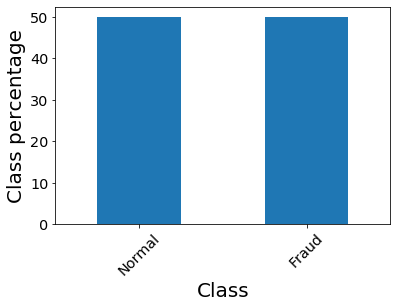

In [20]:
((sub_sampled_data.Class.value_counts()/sub_sampled_data.shape[0])*100).plot(kind = 'bar')
plt.xlabel('Class', fontsize = 20)
plt.ylabel('Class percentage', fontsize = 20)
plt.xticks([0,1], ("Normal", "Fraud"), rotation=45)
plt.show()

Lets study the correlation of the features in these data with the class

In [21]:
#taking a look at correlations once more
corr = sub_sampled_data.corr()
corr = corr[['Class']]

In [22]:
#negative correlations smaller than -0.5
corr[corr.Class < -0.5]

,Class
V3,-0.572970
V9,-0.566012
V10,-0.622799
V12,-0.678746
V14,-0.745254
V16,-0.595842
V17,-0.551607


Visualizing the negatively correlated ones. We note that there plot clearly illustrate these correlatios.

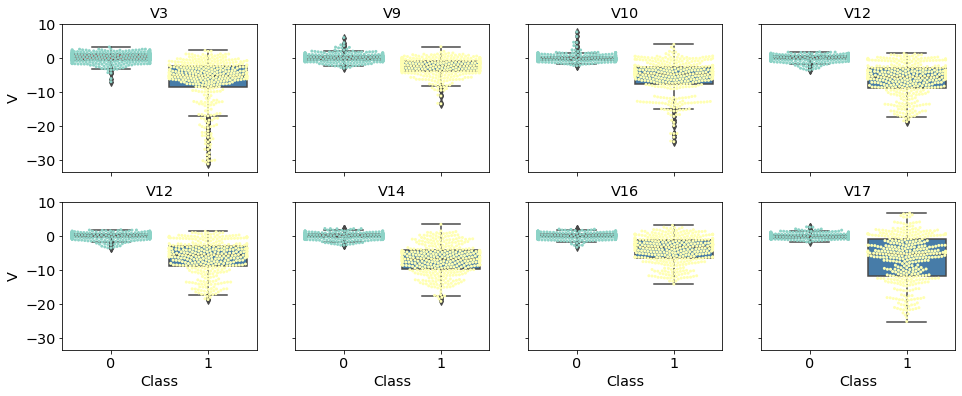

In [23]:
fig, axes = plt.subplots(2, 4, figsize=(16, 6), sharex=True, sharey=True)
for col, ax in zip(['V3', 'V9', 'V10', 'V12', 'V12', 'V14', 'V16', 'V17'], axes.ravel()):
    sns.boxplot(data=sub_sampled_data, x='Class', y=col, ax=ax, palette="Set1")
    sns.swarmplot(data=sub_sampled_data, x='Class', y=col, ax=ax, size=3, palette="Set3", dodge=True)
    ax.set(ylabel='V', title=col)
# Remove the automatic x-axis label from all but the bottom subplot
    if ax in axes[0]:
           ax.set_xlabel('')
    if ax in axes[:,1:]:
           ax.set_ylabel('')

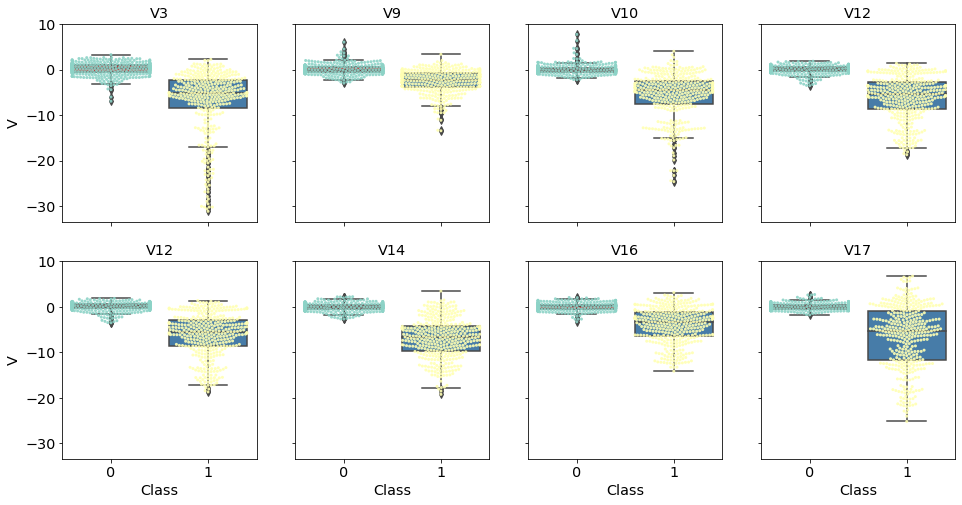

In [24]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharex=True, sharey=True)
for col, ax in zip(['V3', 'V9', 'V10', 'V12', 'V12', 'V14', 'V16', 'V17'], axes.ravel()):
    sns.boxplot(data=sub_sampled_data, x='Class', y=col, ax=ax, palette="Set1")
    sns.swarmplot(data=sub_sampled_data, x='Class', y=col, ax=ax, size=3, palette="Set3", dodge=True, alpha=0.9)
    ax.set(ylabel='V', title=col)
# Remove the automatic x-axis label from all but the bottom subplot
    if ax in axes[0]:
           ax.set_xlabel('')
    if ax in axes[:,1:]:
           ax.set_ylabel('')

In [25]:
#negative correlations smaller than -0.5
corr[corr.Class > 0.5]

,Class
V4,0.723333
V11,0.678132
Class,1.000000


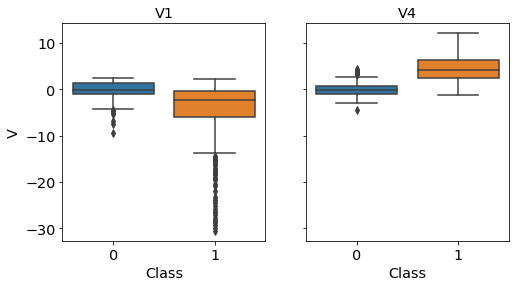

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4),  sharey=True)
for col, ax in zip(['V1', 'V4', 'V10'], axes.ravel()):
    sns.boxplot(data=sub_sampled_data, x='Class', y=col, ax=ax)
    ax.set(ylabel='V', title=col)
# Remove the automatic x-axis label from all but the bottom subplot
    if ax is axes[1]:
           ax.set_ylabel('')

### High dimension data visualization
We apply t-SNE to the data to see how separable it can be. 

In [27]:
X = sub_sampled_data.drop('Class', axis=1)
y = sub_sampled_data['Class']

In [28]:
tsne = manifold.TSNE(n_components=2, perplexity=50)
tsne_results = tsne.fit_transform(X.values)

(-61.966629716247205, 37.7655620235175, -20.040654219181956, 17.53813241405595)

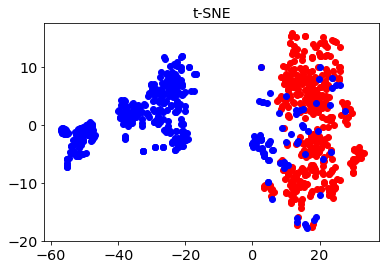

In [29]:
red1 = y.values == 0
green1 = y.values == 1

_, ax = plt.subplots(1,1)
ax.scatter(tsne_results[red1,0], tsne_results[red1,1], c="r", label='Fraud')
ax.scatter(tsne_results[green1,0], tsne_results[green1,1], c="b", label='No Fraud')
#ax.xaxis.set_major_formatter(NullFormatter())
#ax.yaxis.set_major_formatter(NullFormatter())
ax.set_title('t-SNE', fontsize=14)
ax.axis('tight')

Visualizing the data using t-SNE

Time, perplexity=50 in 5 sec
Time, perplexity=60 in 5.2 sec
Time, perplexity=80 in 5.9 sec
Time, perplexity=100 in 6.3 sec


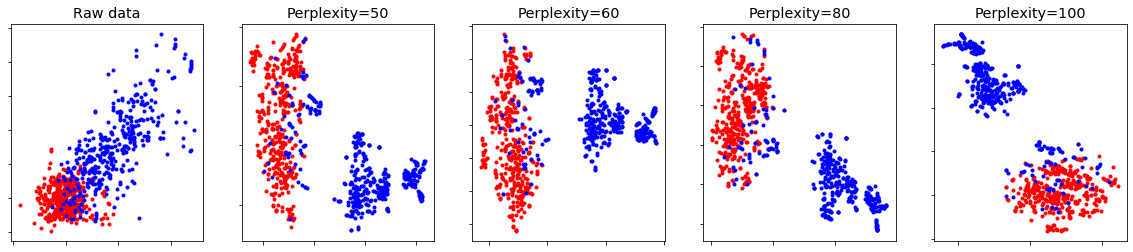

In [30]:
#Parameters for the t-SNE
n_samples = 300
n_components = 2
perplexities = [50, 60, 80, 100] #List to plot

#Setup axis for sequential plots
(fig, subplots) = plt.subplots(1, 5, figsize=(20, 4))

#Set colors
red = y == 0
green = y == 1

ax = subplots[0]
ax.set_title("Raw data")
ax.scatter(X[red].V4, X[red].V11, c="r", marker='.')
ax.scatter(X[green].V4, X[green].V11, c="b", marker='.')
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

for i, perplexity in enumerate(perplexities):
    ax = subplots[i + 1]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("Time, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[red, 0], Y[red, 1], c="r", marker='.')
    ax.scatter(Y[green, 0], Y[green, 1], c="b", marker='.')
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

With such a clearly separable data, let's split the data and train some ML algorithms

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
X_train = X_train.values
X_validation = X_test.values
y_train = y_train.values
y_validation = y_test.values

In [33]:
##List of Algorithms to check

models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))

#testing models
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.980652 (0.022318)
LDA: 0.967735 (0.032083)
KNN: 0.970500 (0.028922)
CART: 0.900932 (0.041600)
SVM: 0.978766 (0.020390)
RF: 0.973974 (0.023708)


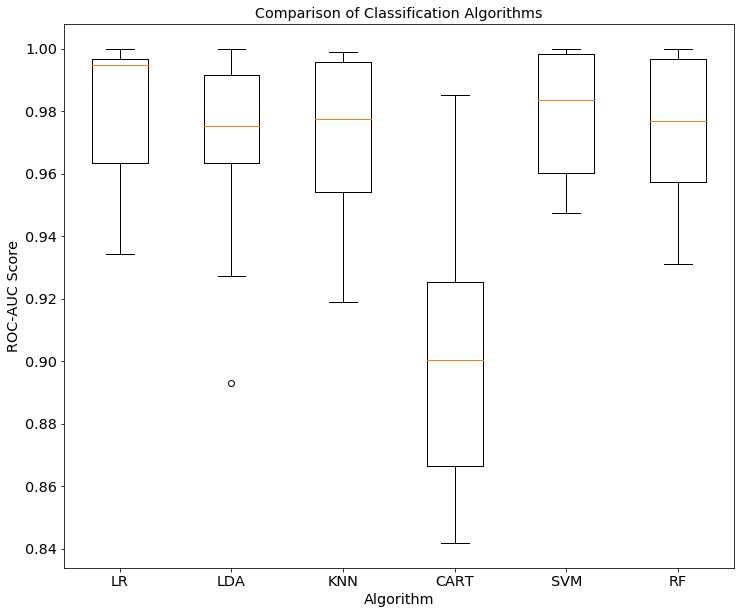

In [34]:
#Compare Algorithms

fig = plt.figure(figsize=(12,10))
plt.title('Comparison of Classification Algorithms')
plt.xlabel('Algorithm')
plt.ylabel('ROC-AUC Score')
plt.boxplot(results)
ax = fig.add_subplot(111)
ax.set_xticklabels(names)
plt.show()

In [35]:
scoring = ['roc_auc', 'recall', 'precision']

In [36]:

#testing models
results2 = []
names2 = []

for name, model in models:
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
    results2.append(cv_results)
    names2.append(name)
    #msg = '%s: %f (%f)' % (name, cv_results.values.mean(), cv_results.std())
    #print(msg)
    #print(name, cv_results)

In [37]:
for name, model in models:
    model.fit(X_train, y_train) # Fit the model on the training set
    y_pred = model.predict(X_test) # Prediction on the validation set
    #y_val_pred = (y_val_pred.max() - y_val_pred)*0.5 # Rescale the prediction
    y_val = y_test
    
    # Evaluate and print model performance
    print('Classifier:', name)
    print('Accuracy: %0.3f' % accuracy_score(y_val, y_pred))
    print('Balanced Accuracy: %0.3f' % balanced_accuracy_score(y_val, y_pred))
    print('AUROC: %0.3f' % (roc_auc_score(y_val, y_pred)))
    print('AUPRC: %0.3f' % (average_precision_score(y_val, y_pred)))
    print('Confusion matrix:\n', confusion_matrix(y_val, y_pred))
    print('Classification report:\n', classification_report(y_val, y_pred))
    print('*********************************************************')

Classifier: LR
Accuracy: 0.937
Balanced Accuracy: 0.938
AUROC: 0.938
AUPRC: 0.925
Confusion matrix:
 [[72  3]
 [ 7 76]]
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.94        75
           1       0.96      0.92      0.94        83

    accuracy                           0.94       158
   macro avg       0.94      0.94      0.94       158
weighted avg       0.94      0.94      0.94       158

*********************************************************
Classifier: LDA
Accuracy: 0.924
Balanced Accuracy: 0.926
AUROC: 0.926
AUPRC: 0.919
Confusion matrix:
 [[73  2]
 [10 73]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92        75
           1       0.97      0.88      0.92        83

    accuracy                           0.92       158
   macro avg       0.93      0.93      0.92       158
weighted avg       0.93      0.92      0.92       158


Let's test it on the hugh data set that contain mostly legimate data.

In [38]:
X_test_2 = data_test.drop(['Class'], axis=1)
y_test_2 = data_test.Class
for name, model in models:
    model.fit(X_train, y_train) # Fit the model on the training set
    y_pred = model.predict(X_test_2) # Prediction on the validation set
    #y_val_pred = (y_val_pred.max() - y_val_pred)*0.5 # Rescale the prediction
    y_val = y_test_2
    
    # Evaluate and print model performance
    print('Classifier:', name)
    print('Accuracy: %0.3f' % accuracy_score(y_val, y_pred))
    print('Balanced Accuracy: %0.3f' % balanced_accuracy_score(y_val, y_pred))
    print('AUROC: %0.3f' % (roc_auc_score(y_val, y_pred)))
    print('AUPRC: %0.3f' % (average_precision_score(y_val, y_pred)))
    print('Confusion matrix:\n', confusion_matrix(y_val, y_pred))
    print('Classification report:\n', classification_report(y_val, y_pred))
    print('*********************************************************')

Classifier: LR
Accuracy: 0.942
Balanced Accuracy: 0.935
AUROC: 0.935
AUPRC: 0.025
Confusion matrix:
 [[53575  3289]
 [    7    91]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     56864
           1       0.03      0.93      0.05        98

    accuracy                           0.94     56962
   macro avg       0.51      0.94      0.51     56962
weighted avg       1.00      0.94      0.97     56962

*********************************************************
Classifier: LDA
Accuracy: 0.980
Balanced Accuracy: 0.903
AUROC: 0.903
AUPRC: 0.055
Confusion matrix:
 [[55719  1145]
 [   17    81]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.83      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.90      0.56     56962
weighted avg       1.00      0

We see that KNN, CART, and RF have a better AU-ROC compared to the others. They also have a higher performance in the recall and precission. However, there are a about about 4 - 10 % legimate transaction that are missed with is not usually a prolem. In comparison,  as comparison 6 - 10 % of the fraudulent ones are missed. To conclude, these models would be optimized to pick the best. 
It is worth noting that the performance is pretty good for a system that we build with only with 0.28% of the data. 

In the next notebook, we will use most of the data by employing the Imbalance library and use a technique more closed to semi-supervised.

In [39]:
sub_sampled_data.shape[0]/df.shape[0]

0.0027667859287166395

In [40]:
y_pred = lr_cl.predict(X_test)

NameError: name 'lr_cl' is not defined

In [ ]:
rf =  RandomForestClassifier().fit(X_train, y_train) # Fit the model on the training set
y_val_pred = model.predict(X_test) # Prediction on the validation set
#y_val_pred = (y_val_pred.max() - y_val_pred)*0.5 # Rescale the prediction
y_val = y_test

# Evaluate and print model performance
print('Classifier:', name)
print('Accuracy: %0.3f' % accuracy_score(y_val, y_val_pred))
print('AUROC: %0.3f' % (roc_auc_score(y_val, y_val_pred)))
print('AUPRC: %0.3f' % (average_precision_score(y_val, y_val_pred)))
print('Confusion matrix:\n', confusion_matrix(y_val, y_val_pred))
print('Classification report:\n', classification_report(y_val, y_val_pred))
print('*********************************************************')

Let's test over the legimatimate transactions that were filtered as well as the first fraudulent transactions

In [ ]:
y_val_pred = rf.predict(data_test.drop('Class', axis=1)) # Prediction on the validation set
#y_val_pred = (y_val_pred.max() - y_val_pred)*0.5 # Rescale the prediction
y_val = data_test.Class

# Evaluate and print model performance
print('Classifier:', name)
print('Accuracy: %0.3f' % accuracy_score(y_val, y_val_pred))
print('AUROC: %0.3f' % (roc_auc_score(y_val, y_val_pred)))
print('AUPRC: %0.3f' % (average_precision_score(y_val, y_val_pred)))
print('Confusion matrix:\n', confusion_matrix(y_val, y_val_pred))
print('Classification report:\n', classification_report(y_val, y_val_pred))
print('*********************************************************')

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

# Setting refit='AUC', refits an estimator on the whole dataset with the
# parameter setting that has the best cross-validated AUC score.
# That estimator is made available at ``gs.best_estimator_`` along with
# parameters like ``gs.best_score_``, ``gs.best_params_`` and
# ``gs.best_index_``
gs = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid={'min_samples_split': range(2, 403, 10)},
                  scoring=scoring, cv=5, refit='AUC', return_train_score=True)
gs.fit(X_train, y_train)
results = gs.cv_results_

Plotting the result

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("min_samples_split")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0, 402)
ax.set_ylim(0.73, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_min_samples_split'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

In [ ]:
from inspect import signature
# Create a simple classifier
classifier = SVC()
classifier.fit(X_train, y_train)
y_score = classifier.decision_function(X_test)

precision, recall, _ = precision_recall_curve(y_val, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
#plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [ ]:
len(y_val[y_val==1])

Let's do hyperparameter tuning

In [ ]:
k_values = np.linspace(0.01,1,10)
oneclass_svm_models = [OneClassSVM(kernel = 'rbf', gamma = 'auto', nu = k).fit(X_train_scaled) for k in k_values]
model_preds = [model.predict(X_val_scaled) for model in oneclass_svm_models]
rescaled_preds = [(svm_anomalies.max() - svm_anomalies)/2 for svm_anomalies in model_preds]
average_precision = [average_precision_score(y_val.values, y_pred) for y_pred in rescaled_preds]
auc = [roc_auc_score(y_val.values, y_pred) for y_pred in rescaled_preds]


Training a machine learning model on an imbalanced dataset can introduce unique challenges to the learning problem. Imbalanced data typically refers to a classification problem where the number of observations per class is not equally distributed; often you'll have a large amount of data/observations for one class (referred to as the majority class), and much fewer observations for one or more other classes (referred to as the minority classes). For example, suppose you're building a classifier to classify a credit card transaction a fraudulent or authentic - you'll likely have 10,000 authentic transactions for every 1 fraudulent transaction, that's quite an imbalance!

In [ ]:
import numpy as np
a = np.random.randn(4, 3) # a.shape = (4, 3)
b = np.random.randn(3, 2) # b.shape = (3, 2)
c = a.dot(b)

In [ ]:
c.shape

In [ ]:
a = np.random.randn(3, 3)
b = np.random.randn(3, 1)
c = a*b

In [ ]:
c

In [ ]:
a

In [ ]:
b

In [ ]:
a[0]*b[0]

In [ ]:
a = np.array([[1,2],[3,4]])
b = np.array([[4],[5]])
c = a*b

In [ ]:
c

In [ ]:
a[0]*b[0]